# Spike sorting workflow

In [1]:
%load_ext autoreload
%autoreload 2
from herdingspikes import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## import the detected spikes

In [2]:
# load an unsorted data set recorded at 24kHz (1024 channels, 42um pitch)
path = '/data/MEA/LightStim/P29_16_07_14/HdfFilesSpkD45_dev/'
fname = 'P29_16_05_14_retina02_left_stim2_smallarray_fullfield_v28.hdf5'
O = ImportInterpolated(path+fname, shapesrange=(18,62))
# cut-outs are longer than required, so cropped here between frame 18 and 62

herdingspikes.py:169: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(rateMasked), cmap=cmap, extent=[xb.min(), xb.max(), yb.min(), yb.max()], interpolation='none', origin='lower')


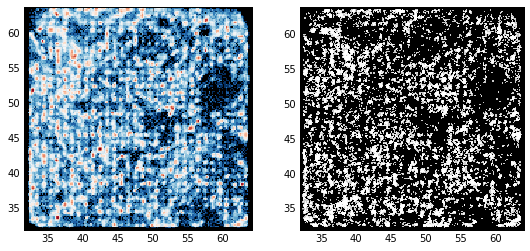

In [3]:
plt.figure(figsize=(9,4))
ax = plt.subplot (121)
O.LogHistPlot(ax=ax, binstep=0.2);
ax = plt.subplot(122)
O.DataPlot(ax=ax, show_max=int(2e4));

## remove noise

Spikes are detected with a low threshold and minimal shape criteria to minimise false negatives. The plots above show that areas where little or no activity was recorded still contain events. These are removed in the following with a classifier, which is a support vector machine trained on examples of events found in low density regions and events with larger amplitudes. 

In [4]:
# compute PCA
%time
scorePCA = O.ShapePCA(ncomp=4, white=True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs
Starting sklearn PCA...
using all 440251 shapes...
done.


Working with 112 examples of bad shapes.
Working with 299048 examples of good shapes.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs
Classified as bad: 119132, and as good: 321119


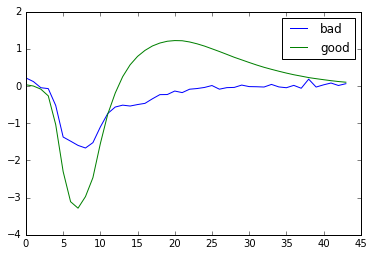

In [5]:
# obtain training data, train the classifier with a subset and then assign spikes to their classes
SC = O.ShapeClassifier()
badshape, indbad = SC.BadShapesByDensity(percentile=0.5, min_thr=1)
goodshape, indgood = SC.GoodShapesByAmplitude(2.5)
plt.plot(badshape, label = 'bad')
plt.plot(goodshape, label='good')
plt.legend()
%time
shapeScore = SC.FitClassifier(scorePCA, indgood[:1000], indbad[:1000])

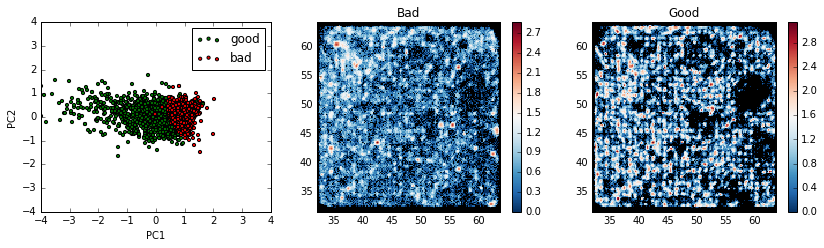

In [6]:
plt.figure(figsize=(14,3.4))
plt.subplot(131)
plt.scatter(scorePCA[0,shapeScore==1][:1000], scorePCA[1,shapeScore==1][:1000], c='g', label='good', s=10)
plt.scatter(scorePCA[0,shapeScore==0][:1000], scorePCA[1,shapeScore==0][:1000], c='r', label='bad', s=10)
plt.xlim((-4,4))
plt.ylim((-4,4))
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
ax = plt.subplot(132)
O.LogHistPlot(ax=ax, binstep=0.2, inds=shapeScore==0);
plt.title('Bad')
plt.colorbar()
ax = plt.subplot(133)
O.LogHistPlot(ax=ax, binstep=0.2, inds=shapeScore==1);
plt.colorbar()
plt.title('Good')

This procedure removes many events that are either very likely noise as they were detecetd in areas without any clear spatial clustering, or small events without a clear spike signature (in particular the positive repolarisation phase). Note that while the first principal component predictes the separation well, the decision boundary is not linear. 

In [7]:
# remove all events classified as noise
O.KeepOnly(shapeScore==1)

## cluster the remaining events into single units

In [8]:
%%time
O.CombinedMeanShift(0.3, 0.28, PrincComp=scorePCA[:2,shapeScore==1] )

Starting sklearn Mean Shift... 
done.
CPU times: user 1min, sys: 13.4 s, total: 1min 14s
Wall time: 5min 24s


In [9]:
print('Found '+str(O.NClusters())+' clusters for '+str(O.NData())+' spikes.')

Found 2888 clusters for 321119 spikes.


herdingspikes.py:242: UserWarning: Only the first 12 of the given clusters are shown
  warnings.warn("Only the first 12 of the given clusters are shown")


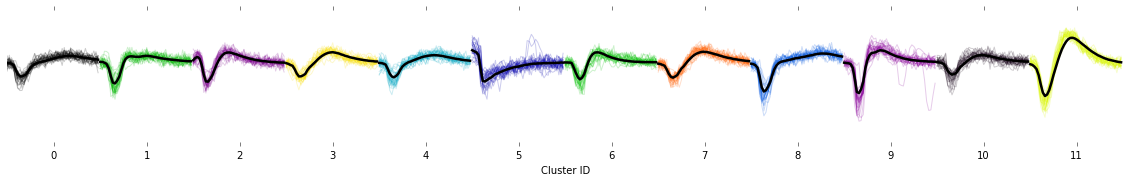

In [10]:
# show waveforms of 12 example clusters
O.ShapesPlot()

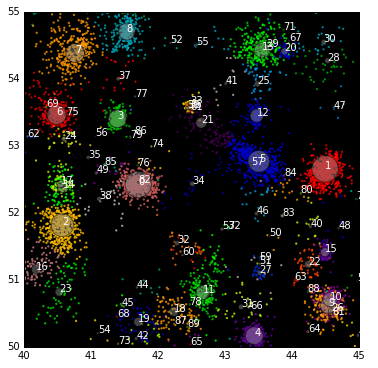

In [11]:
plt.figure(figsize=(6,6))
O.PlotRegion((40,45,50,55), ax=plt.gca())

## the quality of the clustering can be assessed by computing a confusion matrix using a fit with a mixtures of Gaussians model

In [12]:
Q=O.QualityMeasures(scorePCA=scorePCA[:,shapeScore==1])

In [13]:
%%time
# Here all clusters with at least 100 spikes are assessed in turn.
# Their nearest neighbours are found, and a Gaussian mixture is fit to the combined data.
# Responsibilities are then used to compute a confusion maric, which yields false positives and negatives.
clusters = np.where(O.ClusterSizes()>100)[0]
fp = np.zeros(len(clusters))
fn = np.zeros(len(clusters))
for i,c in enumerate(clusters):
    cl = np.hstack((c,Q.Neighbours(c, 1., min_neigh_size=100)))
    conf = Q.GaussianOverlapGroup(cl)
    fp[i] = conf[0,0]
    fn[i] = np.sum(conf-np.diag(np.diag(conf)),axis=0)[0]


CPU times: user 57.8 s, sys: 70 ms, total: 57.9 s
Wall time: 58.3 s


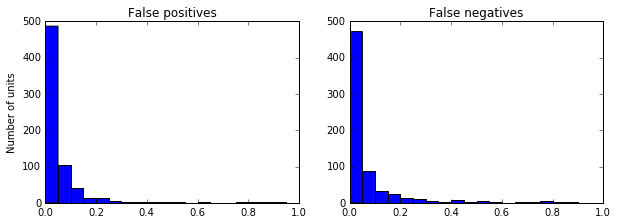

In [14]:
plt.figure(figsize=(10,3.25))
plt.subplot(121)
plt.hist(fp, bins=np.arange(0,1,0.05))
plt.title('False positives')
plt.ylabel('Number of units')
plt.subplot(122)
plt.hist(fn, bins=np.arange(0,1,0.05))
plt.title('False negatives')

## now crop out a small section of the data set to evaluate the effect of the clustering parameters quickly

Crop removed 2778 clusters and 306861 datapoints.
110 clusters found.


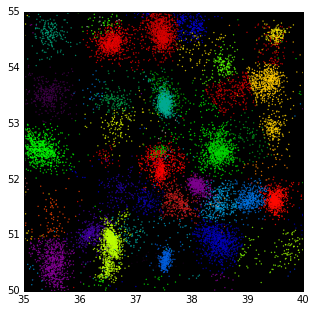

In [15]:
cropInds, cropCl = O.Crop((35, 40, 50, 55))
cropPCA = scorePCA[:,shapeScore==1][:, cropInds]
O.DataPlot(figsize=(5,5), show_max=None)
print(str(O.NClusters())+" clusters found.")

The original clusters, obtained by clustering combined location and shape parameter.

Starting sklearn Mean Shift... 
done.
253 clusters found.
CPU times: user 887 ms, sys: 59 ms, total: 946 ms
Wall time: 5.93 s


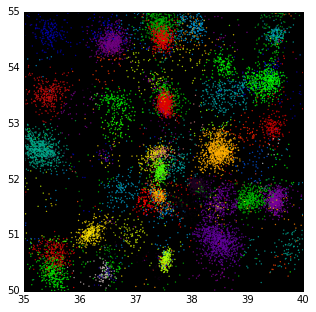

In [16]:
%%time
O.CombinedMeanShift(0.3, 0.5, PrincComp=cropPCA[:2] )
O.DataPlot(figsize=(5,5), show_max=None)
print(str(O.NClusters())+" clusters found.")

More weight on shapes causes clusters to be broken apart (parameter $\alpha=0.5$).

Starting sklearn Mean Shift... 
done.
30 clusters found.
CPU times: user 373 ms, sys: 45 ms, total: 418 ms
Wall time: 930 ms


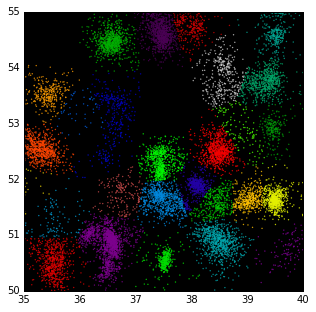

In [17]:
%%time
O.CombinedMeanShift(0.3, 0.0, PrincComp=cropPCA[:2] )
O.DataPlot(figsize=(5,5), show_max=None)
print(str(O.NClusters())+" clusters found.")

Using only spatial information ($\alpha=0$) causes merging of clusters.